## Filtrado de correos spam

En esta ocasión vamos a ver una solución al famoso problema de clasificación de correos **spam**/**ham** para el consecuente filtrado de los no deseados. Es un tipo de ejercicio en el que se requiere hacer uso de técnicas de **procesamiento de lenguaje natural**, para generar un conjunto de datos que puedan ser introducidos como entrada al modelo clasificador entrenado. A lo largo de este *notebook* se irá explicando paso por paso las operaciones realizadas sobre el conjunto de correos original.

## Datos

La base de datos esta formada por un total de 3052 correos electrónicos de entre los cuales 2551 están etiquetados como *ham* y 501 como *spam*. Este conjunto de datos puede encontrarse en la página oficial de Apache SpamAssassin, siguiendo el siguiente enlace: http://spamassassin.apache.org/old/publiccorpus/

In [1]:
import os
import numpy as np
import pandas as pd
import email
import email.policy
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import spacy
import urlextract    
import re
from scipy.sparse import csr_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('dark')
%matplotlib inline


In [2]:
spam_path='datasets/mails/spam'
ham_path='datasets/mails/ham'

Cargamos los correos previamente descargados de forma separada en dos carpetas distintas. Para ello hacemos uso de la libreria **email** (la cual se irá utilizando durante toda la resolución del problema) de Python, con la que es posible hacer un parseo por bytes de los mismos.

In [3]:
def load_mails(spam_path, ham_path):
    spam_list=[]
    ham_list=[]
    for mail_name in os.listdir(spam_path):
        with open(spam_path+'/'+mail_name, 'rb') as file:
            spam_list.append(email.parser.BytesParser(policy=email.policy.default).parse(file))
    for mail_name in os.listdir(ham_path):
        with open(ham_path+'/'+mail_name, 'rb') as file:
            ham_list.append(email.parser.BytesParser(policy=email.policy.default).parse(file))  
    return (spam_list,ham_list)

In [4]:
spam_list, ham_list=load_mails(spam_path,ham_path)

Antes de nada generamos los *numpy array* de correos y etiquetas, que utilizamos para separar nuestro set de entrenamiento y set de testeo

In [5]:
X=np.concatenate((np.array(spam_list), np.array(ham_list)), axis=0)
y=np.concatenate((np.ones(len(spam_list)).astype(np.int8), np.zeros(len(ham_list), dtype=int)))

In [6]:
X.shape, y.shape

((3052,), (3052,))

In [7]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2441,), (2441,), (611,), (611,))

Mediante esta línea de código se carga el modelo (de lengua inglesa) perteneciente a la librería **Spacy**.

Spacy es el framework de procesamiento de lenguaje natural más empleado junto con **NLTK**(*Natural Language Toolkit*). En esta ocasión lo utilizaremos para hacer:
- **tokenización** de los correos: separar las oraciones en palabras y símbolos.
- **lematización**: obtener el lema de cada palabra, esto es, la palabra representativa de todas las formas flexionadas de una palabra.
- **etiquetado gramatical**: asignar a cada una de las palabras de un texto su categoría gramatical
- **reconocimiento del tipo de entidad**: asignar a que se corresponde cada sustantivo de la oración.

Haremos uso por otro lado de las **expresiones regulares** (librería **re**) para hacer ciertas búsquedas de secuencias de caracteres en los correos, así como sustituciones. 

In [9]:
tokenizer=spacy.load('en_core_web_sm')


A continuación creamos la función que se encarga de procesar el **contenido** de cada correo electrónico de la base de datos. El objetivo es hacer una normalización y limpieza de lo mismos, para no encontrarnos más adelante con demasiadas columnas en el *dataframe*.

1. Comenzamos haciendo un *strip* del contenido.
2. A través de la librería **urlextract** buscamos todas aquellas direcciones y las sustituimos por **'url_link'**.
3. Generamos una expresión regular para encontrar cualquier dirección de correo electronico, de entre todos los formatos admitidos, y las sustituimos por **'mail_dir'**.
4. Tokenizamos el contenido del mensaje y, de todos los sustantivos, sustituimos los que presenten las siguientes etiquetas:
    - ORG: organizaciones
    - GPE: situaciones geográficas
    - PERSON: personas
    
5. 6. 7. 8. y 9. Sustituimo cada una de las expresiones que se repitan más de dos veces, por la misma expresión repetida dos veces.


In [10]:
def preprocess_mails(mail_content):
    #1.- Strip
    mail_copy_content=mail_content.strip()
    
    #2.-URLS
    extractor=urlextract.URLExtract()
    urls=extractor.find_urls(mail_copy_content)
    for url in urls:
        mail_copy_content=mail_copy_content.replace(url, 'url_link')
   
    #3.-CORREOS
    mail_copy_content=re.sub('\w+(\.\w+|-\w+)*@\w+\.\w+(\.\w+)*', 'mail_dir',mail_copy_content, flags=re.IGNORECASE)

    #4.- person, org , gpe
    tokens=tokenizer(mail_copy_content)
    for ent in tokens.ents:
        if (ent.label_ in ['GPE','ORG', 'PERSON']) and (str(ent)!='url_link') and (str(ent)!='>'):
            mail_copy_content=mail_copy_content.replace(str(ent), ent.label_)
   
    #5 '  '
    mail_copy_content=re.sub(' ( )+', '  ', mail_copy_content, flags=re.IGNORECASE)

    #6 '\n\n'
    mail_copy_content=re.sub('\n(\n)+', '\n\n', mail_copy_content, flags=re.IGNORECASE)
   
    7# '=='
    mail_copy_content=re.sub('=(=)+', '==', mail_copy_content, flags=re.IGNORECASE)

    #8 '\xa0\xa0'
    mail_copy_content=re.sub('\xa0(\xa0)+', '\xa0\xa0', mail_copy_content, flags=re.IGNORECASE)
 
    #9 '--'
    mail_copy_content=re.sub('-(-)+', '--', mail_copy_content, flags=re.IGNORECASE)
    
    return mail_copy_content

A continuación definimos la función que se encarga de obtener la matriz dispersa del contenido de cada mensaje.

Para ello tenemos que diferenciar en primer lugar el tipo de mensaje que es, ya que no todos presentan la misma estructura. En caso de tratarse de un correo *multipart* habrá que ir recorriendo los diferentes subapartados.

Mediante la librería **BeautifulSoup** hacemos un parseo de aquellos mensajes que presenten estructuras en formato html, para deshacernos de sus respectivas etiquetas, ya que no las queremos. Del resultado de esta operación realizamos el preprocesamiento y posteriormente la tokenización.

Para cada **token** (si viene recogido en el modelo previamente cargado), añadimos su lema o su etiquetado en la lista **doc**.

La lista **docs** contiene el cada una de las listas **doc** correspondiente a cada mensaje. Esta lista la utilizamos en la función **csr_matrix** de la librería **Scipy** para generar finalmente la matriz dispera. 

In [52]:
def get_content_sparse_matrix(X):
    multipart_array=['multipart/signed', 'multipart/alternative','multipart/mixed', 'multipart/related', 'multipart/report']
    docs=[]
    begins=time.time()
    for email in X:
        doc=[]
        try:
            if email.get_content_type() in multipart_array:
                for part in email.walk():
                    if isinstance(part, str):
                        tokens=tokenizer(preprocess_mails(BeautifulSoup(part.get_payload(), 'html.parser').get_text()))
                        for token in tokens:
                            if not token.is_stop:
                                if token.pos_!='PROPN':
                                    doc.append(token.lemma_)
                        for ent in tokens.ents:
                            if ent.label_ in ['GPE','ORG', 'PERSON']:
                                doc.append(ent.label_)
                docs.append(doc)
                            
                   
            else:
                tokens=tokenizer(preprocess_mails(BeautifulSoup(email.get_payload(), 'html.parser').get_text()))
                for token in tokens:
                    if not token.is_stop:
                        if token.pos_!='PROPN':
                            doc.append(token.lemma_)
                for ent in tokens.ents:
                    if ent.label_ in ['GPE','ORG', 'PERSON']:
                        doc.append(ent.label_)
                docs.append(doc)


        except KeyError:
            pass
        except LookupError:
            pass
        except TypeError:
            pass
    
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    print(f'Elapsed time: {int(time.time()-begins)} seconds')
    return (csr_matrix((data, indices, indptr), dtype=int).toarray(), [key for key in vocabulary.keys()], docs)
                                         
                                         
    

In [12]:
content_sparse_matrix, content_columns, docs=get_content_sparse_matrix(X_train)

/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Elapsed time: 230 seconds


Generamos el **dataframe** correspondiente a la matriz previamente obtenida.

In [13]:
content_df=pd.DataFrame(content_sparse_matrix, columns=content_columns)

In [14]:
content_df.head()

,\n,\n\n,lowest,rate,45,year,-,fill,short,application,...,submarine,inertial,submerge,seismic,marine,magnetometer,declassify,hazily,geophysicist,quake
0,20,11,1,1,1,1,5,1,3,3,...,0,0,0,0,0,0,0,0,0,0
1,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60,7,0,0,0,0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,31,6,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Hacemos de nuevo la función para obtener la matriz dispersa, pero esta vez para el asunto del mensaje y generamos su correspondiente *dataframe*:

In [15]:
def get_subject_sparse_matrix(X):
    docs=[]
    begins=time.time()
    for email in X:
        doc=[]
        try:
            tokens=tokenizer(preprocess_mails(BeautifulSoup(email['subject'], 'html.parser').get_text()))
            for token in tokens:
                if not token.is_stop:
                    if token.pos_!='PROPN':
                        doc.append(token.lemma_)
            for ent in tokens.ents:
                if ent.label_ in ['GPE','ORG', 'PERSON']:
                    doc.append(ent.label_)
            docs.append(doc)
            
        except KeyError:
            pass
        except LookupError:
            pass
        except TypeError:
            pass
    
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    print(f'Elapsed time: {int(time.time()-begins)} seconds')
    return (csr_matrix((data, indices, indptr), dtype=int).toarray(), [key for key in vocabulary.keys()], docs)
                                         
                                         

In [16]:
subject_sparse_matrix, subject_columns, docs=get_subject_sparse_matrix(X_train)

/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning: "http://apt.nixia.no/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning: "http://www.efi.ie/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Elapsed time: 80 seconds


In [17]:
subject_columns=list(map(lambda x: x+'_subj' , subject_columns))


In [18]:
subject_df=pd.DataFrame(subject_sparse_matrix, columns=subject_columns)

In [19]:
subject_df.head()

,let_subj,know_subj,think!32482_subj,[_subj,]_subj,spambaye_subj,package_subj,?_subj,:_subj,ignore_subj,...,spectacular_subj,retreat_subj,goodz_subj,8simugq_subj,handle_subj,allow_subj,arbitrary_subj,execute_subj,plate_subj,tectonic_subj
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Vamos a estudiar la distribución de la variable **'tipo de mensaje'** a ver si sacamos algún valor de la ella:

In [20]:
def get_content_type_array(X):
    content_types=[]
    for email in X:
        content_types.append(email.get_content_type())
    return content_types


In [21]:
content_type_array=get_content_type_array(X_train)
X_train_w_ct=pd.DataFrame(np.c_[np.array(content_type_array), y_train.astype(np.int8)], columns=['content_type', 'target'])

text/plain               2138
text/html                 146
multipart/signed           65
multipart/alternative      44
multipart/mixed            40
multipart/related           6
multipart/report            2
Name: content_type, dtype: int64


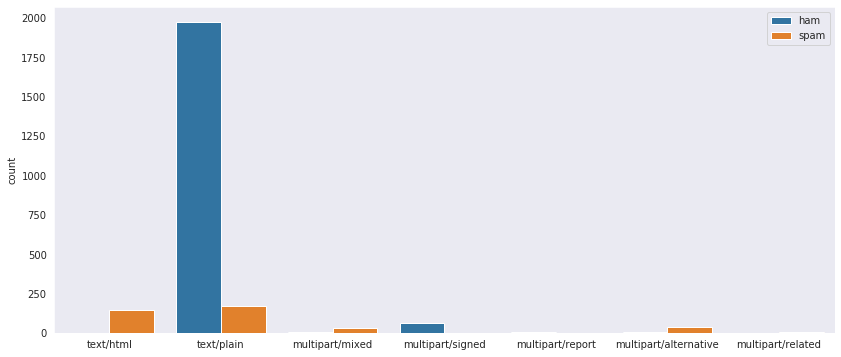

In [22]:
print(X_train_w_ct['content_type'].value_counts())
figure =plt.figure(figsize=(14,6))
g1=sns.countplot(x='content_type', hue='target',data=X_train_w_ct)
g1.legend([ 'ham','spam'], loc='upper right');
g1.set_xlabel('');

Vemos que efectivamente, esta variable puede sernos de gran ayudar para la tarea de clasificación, entonces la añadimos al *dataframe* final de los datos de entrenamiento.

In [23]:
content_type_df=pd.get_dummies(content_type_array, drop_first=True)

In [24]:
X_train_pd=pd.concat([content_df, subject_df,content_type_df], axis=1)
y_train_pd=pd.Series(y_train, name='target')

In [25]:
X_train_pd.head()

,\n,\n\n,lowest,rate,45,year,-,fill,short,application,...,arbitrary_subj,execute_subj,plate_subj,tectonic_subj,multipart/mixed,multipart/related,multipart/report,multipart/signed,text/html,text/plain
0,20,11,1,1,1,1,5,1,3,3,...,0,0,0,0,0,0,0,0,1,0
1,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,60,7,0,0,0,0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,1,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,31,6,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Ha llegado el momento de generar nuestro modelo clasificador. Usaremos una regresión logística, la cual vamos a ajustar a traves de una malla de validación cruzada randomizada.

Posteriormente estudiamos los resultados y vemos como han ido las cosas:

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

In [27]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
param_distributions={'C': expon(scale=1), 'tol':expon(scale=1), 'max_iter':[100,150,200]}
randomized_search=RandomizedSearchCV(log_clf, param_distributions=param_distributions, n_jobs=-1, cv=5, scoring='accuracy', n_iter=200)


In [28]:
randomized_search.fit(X_train_pd, y_train_pd)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=200, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0c6ce246d8>,
                                        'max_iter': [100, 150, 200],
                                        'tol': <scipy.stats._distn_infrastructure.rv

In [29]:
cv_results_df=pd.DataFrame(randomized_search.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.417453,0.034021,0.091958,0.012679,0.00340559,100,0.427638,"{'C': 0.003405585290268786, 'max_iter': 100, '...",0.910020,0.920245,0.932377,0.936475,0.924025,0.924621,0.009313,111
1,2.538855,0.155416,0.110433,0.018707,1.22058,100,0.0636025,"{'C': 1.2205782413950583, 'max_iter': 100, 'to...",0.932515,0.975460,0.948770,0.969262,0.983573,0.961901,0.018677,9
2,2.422230,0.043419,0.099070,0.013408,0.460406,150,0.675929,"{'C': 0.46040553738405554, 'max_iter': 150, 't...",0.903885,0.944785,0.928279,0.963115,0.936345,0.935272,0.019505,77
3,2.353385,0.042457,0.103743,0.019966,0.0224889,200,0.926026,"{'C': 0.022488859587115044, 'max_iter': 200, '...",0.903885,0.918200,0.897541,0.936475,0.917864,0.914789,0.013473,122
4,2.346821,0.100449,0.092348,0.021111,4.48723,150,1.93366,"{'C': 4.4872291164262705, 'max_iter': 150, 'to...",0.889571,0.889571,0.897541,0.932377,0.919918,0.905776,0.017325,175


In [30]:
col_split=re.compile('split')
col_time=re.compile('time')
col_to_drop=[]
for column in cv_results_df.columns:
    if col_split.search(column) or col_time.search(column):
        col_to_drop.append(column)
        
cv_results_df.drop(columns=col_to_drop, inplace=True)
cv_results_df.sort_values('rank_test_score').head()
        

,param_C,param_max_iter,param_tol,params,mean_test_score,std_test_score,rank_test_score
149,0.886866,100,0.0111008,"{'C': 0.8868657577084735, 'max_iter': 100, 'to...",0.984433,0.004588,1
95,0.641906,200,0.013762,"{'C': 0.6419061780025663, 'max_iter': 200, 'to...",0.981155,0.003738,2
51,0.734859,100,0.0229452,"{'C': 0.7348588852607294, 'max_iter': 100, 'to...",0.971323,0.010575,3
69,1.07967,200,0.0215767,"{'C': 1.0796660221649614, 'max_iter': 200, 'to...",0.970914,0.011550,4
102,1.0661,200,0.0308276,"{'C': 1.0660996166347303, 'max_iter': 200, 'to...",0.966817,0.007976,5


Los resultados han sido francamente buenos, utilizaremos evidentemente el mejor de los estimadores obtenidos a través de la malla para generar nuestras predicciones sobre el set de testeo y hacer las consecuentes evaluaciones. Pero antes, habrá que repetir todo el procesamiento de los correos al set de testeo y, ajustar las columnas a las utilizadas durante el entrenamiento de nuestro modelo:

In [39]:
#Correo con estructura no válida
#X_test=np.delete(X_test, 344)
#y_test=np.delete(y_test, 344)


In [41]:
#os.system('play -nq -t alsa synth {} sine {}'.format(1, 2500))

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [45]:
content_sparse_matrix_test, content_columns_test, docs_test=get_content_sparse_matrix(X_test)
content_df_test=pd.DataFrame(content_sparse_matrix_test, columns=content_columns_test)
subject_sparse_matrix_test, subject_columns_test, docs_test=get_subject_sparse_matrix(X_test)
subject_columns_test=list(map(lambda x: x+'_subj' , subject_columns_test))
subject_df_test=pd.DataFrame(subject_sparse_matrix_test, columns=subject_columns_test)
content_type_array_test=get_content_type_array(X_test)
content_type_df_test=pd.get_dummies(content_type_array_test, drop_first=True)
X_test_pd=pd.concat([content_df_test, subject_df_test,content_type_df_test], axis=1)
y_test_pd=pd.Series(y_test, name='target')
for col in X_train_pd:
    if col not in X_test_pd.columns:
        X_test_pd[col]=np.zeros(X_test_pd.shape[0], dtype=int)
X_test_pd=X_test_pd[X_train_pd.columns]
test_pred=randomized_search.best_estimator_.predict(X_test_pd)


Elapsed time: 55 seconds
Elapsed time: 20 seconds


In [46]:
accuracy_score(y_test_pd, test_pred)

0.9868852459016394

In [47]:
print(classification_report(y_test_pd, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       497
           1       0.97      0.96      0.96       113

    accuracy                           0.99       610
   macro avg       0.98      0.97      0.98       610
weighted avg       0.99      0.99      0.99       610



In [48]:
cm=confusion_matrix(y_test_pd, test_pred)

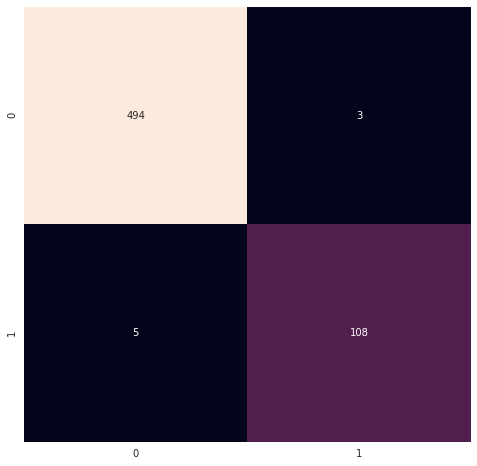

In [49]:
figure=plt.figure(figsize=(8,8))
g1=sns.heatmap(cm, annot=True, fmt='d', cbar=False)